# 03 - Prepare Analysis

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#import linearmodels as lm

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sys
sys.path.append('../')
sys.path.append('../../kungfu/')
import kungfu as kf

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Settings

In [4]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [5]:
%matplotlib inline

In [6]:
#sns.set()
#sns.set(rc={'figure.figsize': (17, 6)})

In [7]:
#plt.style.use('fivethirtyeight')
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [17, 8]
#plt.rcParams['figure.dpi'] = 80

## Load & prepare data
#### Previously saved

In [8]:
df_crsp_desc = pd.read_pickle('../data/raw/df_crsp_desc.pkl')

In [9]:
df_ff_raw = pd.read_pickle('../data/raw/df_ff_raw.pkl')
df_ff_raw['date'] = pd.to_datetime(df_ff_raw['date'], yearfirst=True)
df_ff_raw = df_ff_raw.set_index('date')

In [10]:
df_analysis = pd.read_pickle('../data/processed/df_analysis.pkl')

In [11]:
df_indices = pd.read_pickle('../data/processed/df_indices.pkl')

## Estimate Betas & Calculate Returns

### Define factor models

In [12]:
capm = kf.FactorModel(df_ff_raw['mktrf'])
ff3f = kf.FactorModel(df_ff_raw[['mktrf', 'smb', 'hml']])
c4f = kf.FactorModel(df_ff_raw[['mktrf', 'smb', 'hml', 'umd']])
models = [capm, ff3f, c4f]

In [13]:
analysis_index = pd.MultiIndex.from_arrays([df_indices.stack().values, df_indices.stack().index.get_level_values(1)])
df_analysis = pd.DataFrame(index=analysis_index)

In [14]:
sample_years = df_analysis.index.get_level_values(1).unique()
for year in sample_years:
    # import data
    df_analise = pd.read_csv('../data/processed/yearly/df_analysis_'+str(year)+'.csv')
    df_analise['date'] = pd.to_datetime(df_analise['date'], yearfirst=True)
    df_analise = df_analise.set_index('date')
    
    #capm
    coeff = capm.fit(df_analise).get_estimates()
    coeff.index = pd.MultiIndex.from_product([[int(i) for i in coeff.index],[year]])
    coeff.columns = ['capm_'+i for i in coeff.columns]
    for col in coeff.columns:
        df_analysis.loc[list(coeff.index),col] = coeff[col]
        
    #ff3f
    coeff = ff3f.fit(df_analise).get_estimates()
    coeff.index = pd.MultiIndex.from_product([[int(i) for i in coeff.index],[year]])
    coeff.columns = ['ff3f_'+i for i in coeff.columns]
    for col in coeff.columns:
        df_analysis.loc[list(coeff.index),col] = coeff[col]
        
    #c4f
    coeff = c4f.fit(df_analise).get_estimates()
    coeff.index = pd.MultiIndex.from_product([[int(i) for i in coeff.index],[year]])
    coeff.columns = ['c4f_'+i for i in coeff.columns]
    for col in coeff.columns:
        df_analysis.loc[list(coeff.index),col] = coeff[col]
    
    print(year)

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


In [15]:
df_analysis = df_analysis.astype(float)
df_analysis.to_pickle(path='../data/processed/df_analysis.pkl')

## Calculate returns

In [16]:
for year in sample_years:
    # import data
    df_analise = pd.read_csv('../data/processed/yearly/df_analysis_'+str(year)+'.csv')
    df_analise['date'] = pd.to_datetime(df_analise['date'], yearfirst=True)
    df_analise = df_analise.set_index('date')
    
    # calculate returns
    index = [(int(i), year) for i in df_analise.columns]
    df_analysis.loc[index,'ret1M'] = df_analise.groupby(pd.Grouper(freq='M')).apply(lambda x: (x+1).prod()-1).head(1).squeeze().values
    df_analysis.loc[index,'ret3M'] = df_analise.groupby(pd.Grouper(freq='Q')).apply(lambda x: (x+1).prod()-1).head(1).squeeze().values
    df_analysis.loc[index,'ret12M'] = df_analise.groupby(pd.Grouper(freq='Y')).apply(lambda x: (x+1).prod()-1).head(1).squeeze().values
    df_analysis.loc[index,'ret'] = ((df_analise+1).prod()-1).values

In [17]:
df_analysis = df_analysis.astype(float)
df_analysis.to_pickle(path='../data/processed/df_analysis.pkl')

## Analysis

In [18]:
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


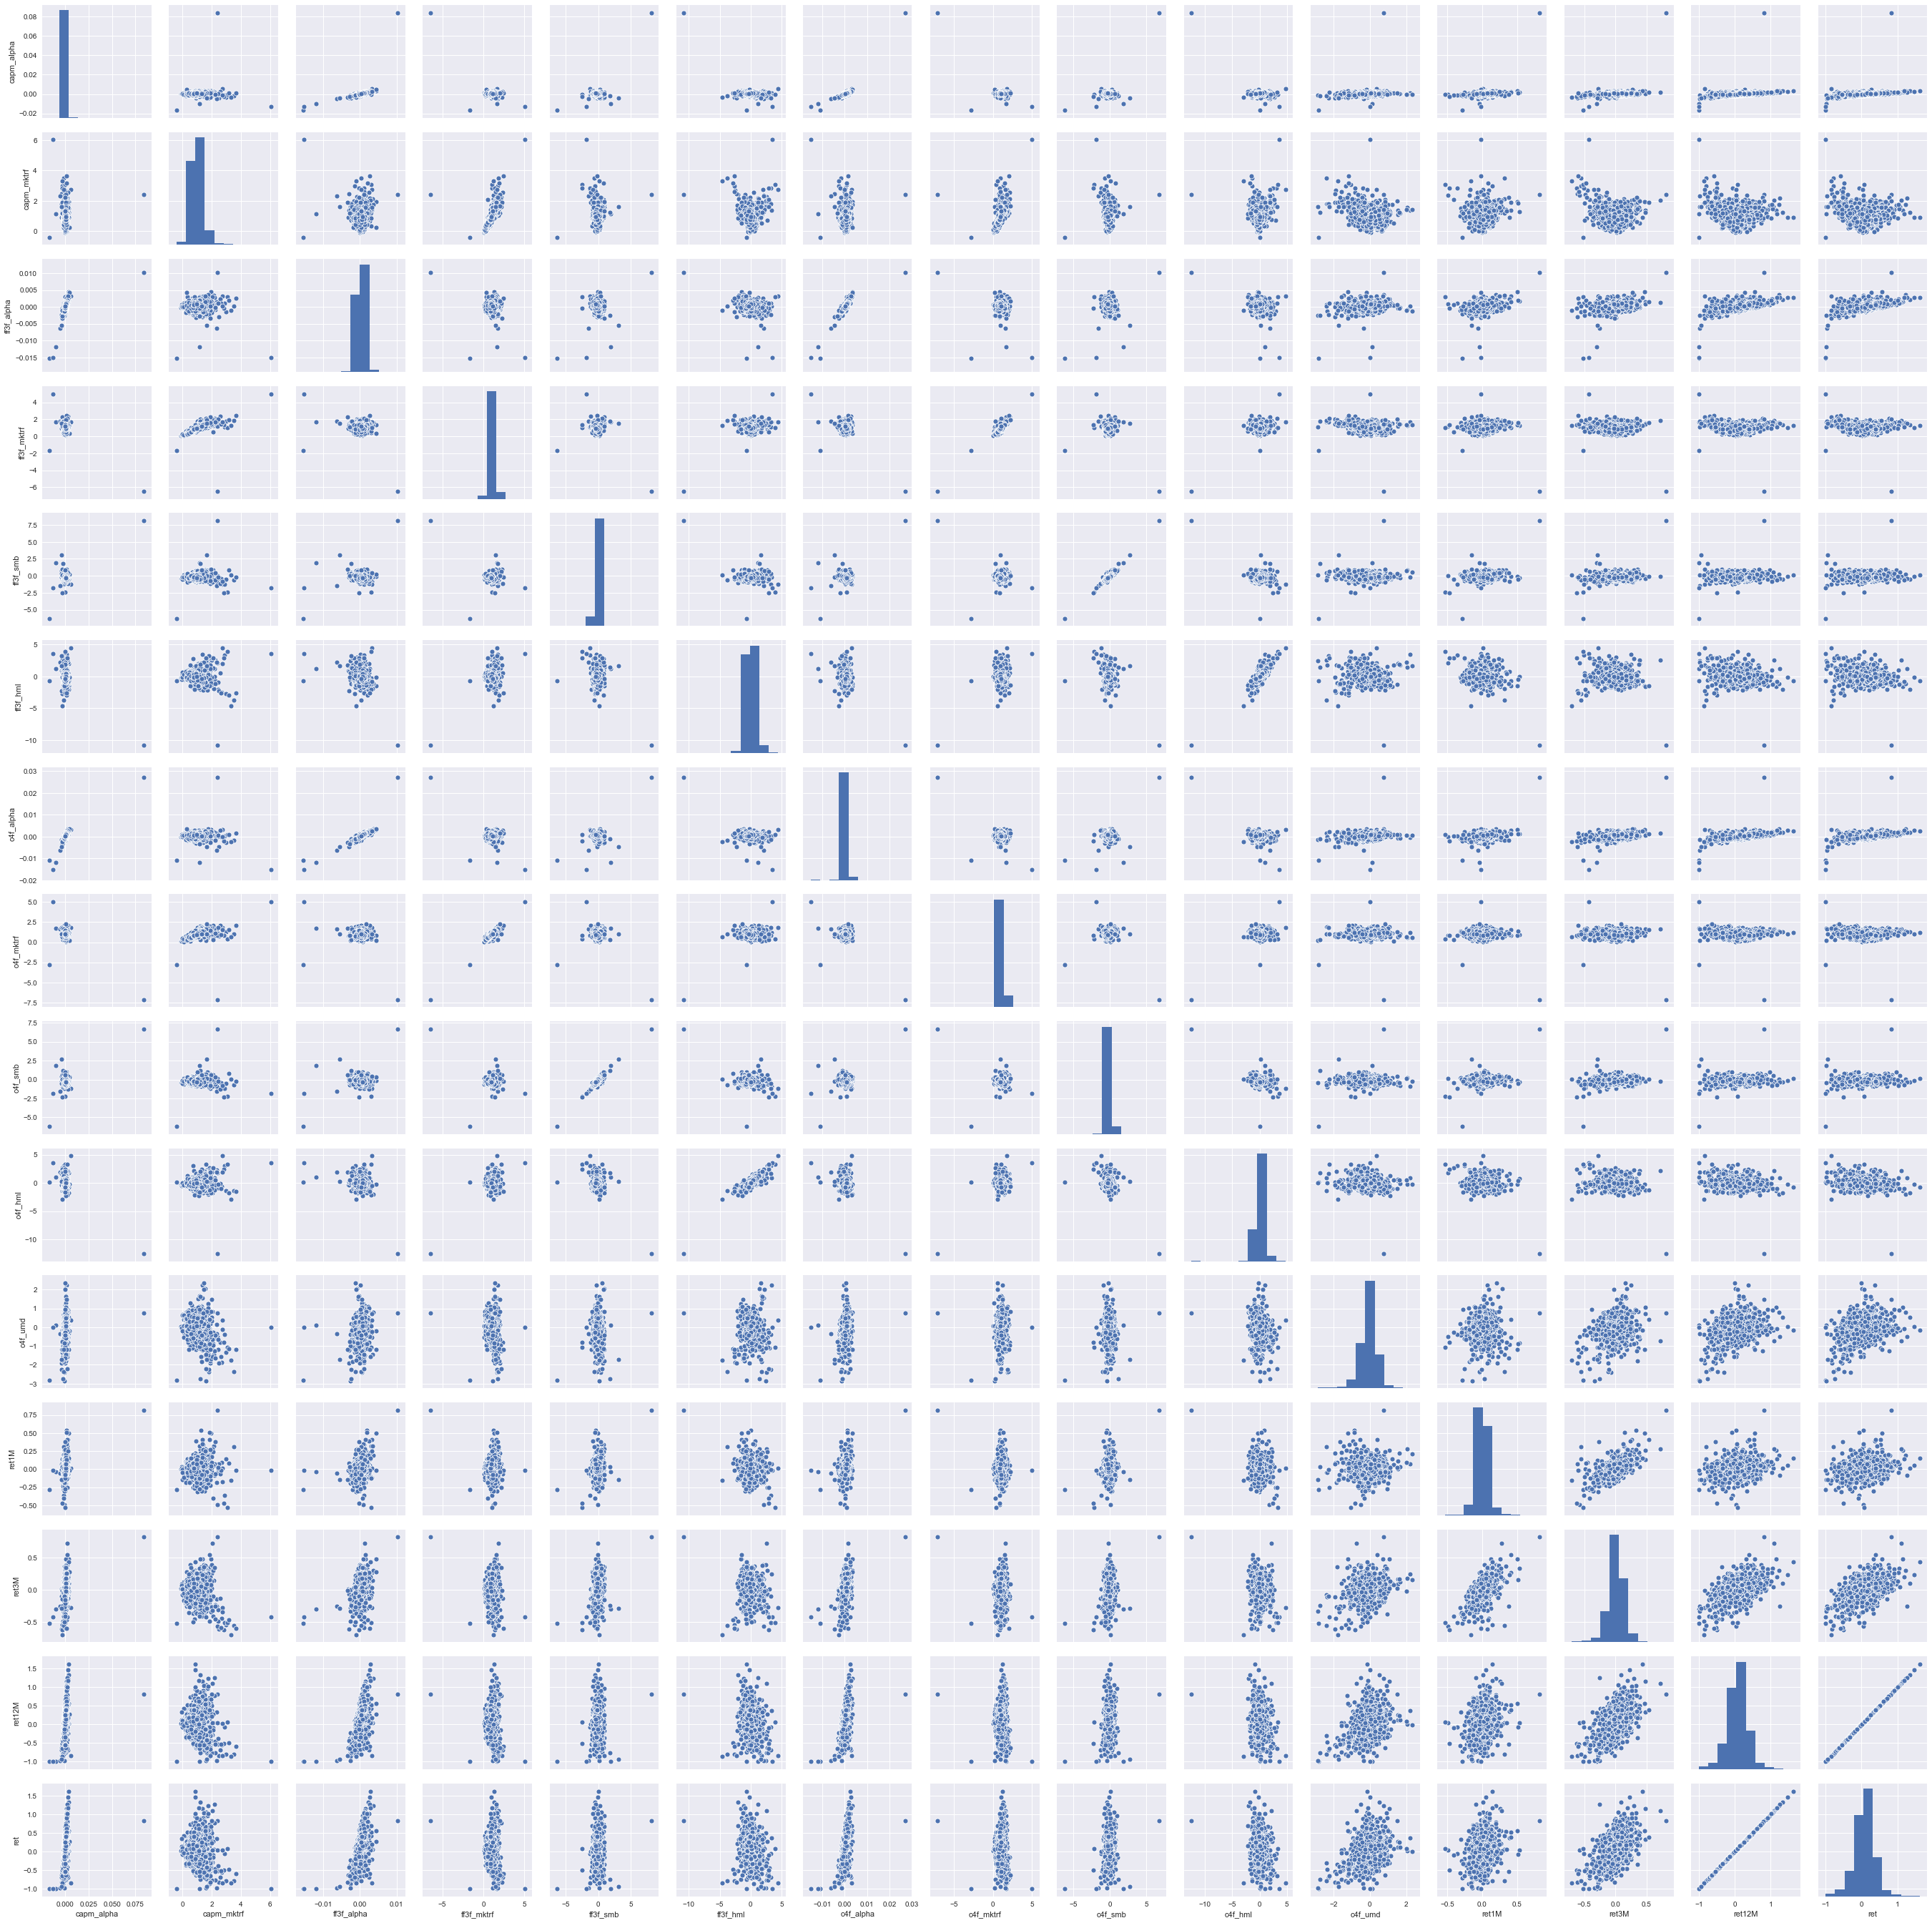

In [19]:
sns.pairplot(df_analysis)